# Concentric Spheres Dataset

This script generates a synthetic dataset consisting of two concentric spheres, meant to mimic a binary classification problem in a 3-dimensional space. The spheres are represented by two sets of data points, one set for each class, with each set forming a sphere of different radius in a 3D space.

First, a seed is set for reproducibility. Two sets of points are generated on the surfaces of two spheres with different radii. Each point on a sphere's surface is computed using randomly generated azimuthal angles and z-coordinates, which are then converted to x, y, and z coordinates using spherical to Cartesian coordinate transformation. A small Gaussian noise is added to these coordinates to simulate real-world measurement errors.

Next, dummy features are added to the dataset. These features are randomly generated and are not related to the target class, simulating irrelevant or noise features often present in real-world datasets. 

Then, correlated features are added. These are derived from the original x, y, z coordinates, being a linear combination of the original feature and some added noise. This mimics scenarios where features are not entirely independent of each other.

Finally, a portion of the values in the dataset is replaced with NaNs to simulate missing data, which is a common challenge in real-world datasets.

The output is a pandas DataFrame that includes the x, y, z coordinates, the target class, an id for each data point, dummy features, correlated features, and the aforementioned simulated missing data.

In [217]:
import numpy as np
import pandas as pd
import os
import random
import string
import math

In [218]:
dataset_name = "concentric_spheres"

In [219]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_test_key_fname = os.path.join(output_dir, f'{dataset_name}_test_key.csv')
outp_infer_instances = os.path.join(output_dir, f'{dataset_name}_infer_req.json')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Generate Data

In [220]:
def set_seed(seed_value=0):
    np.random.seed(seed_value)
    random.seed(seed_value)

In [221]:
def generate_id(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [222]:
def generate_noisy_points_on_sphere(num_points, radius=1, noise_std_dev=0.1):
    """
    Generate points uniformly distributed on the sphere surface with added noise.

    Parameters:
    num_points (int): Number of points to generate.
    radius (float): Radius of the sphere.
    noise_std_dev (float): Standard deviation of the Gaussian noise.

    Returns:
    ndarray: Numpy array with shape (num_points, 3).
    """
    points = np.empty((num_points, 3))

    phi = 2 * np.pi * np.random.rand(num_points)  # azimuthal angle
    z = radius * (2 * np.random.rand(num_points) - 1)  # z coordinates
    r_xy = np.sqrt(radius**2 - z**2)  # projected radius in the xy-plane

    points[:, 0] = r_xy * np.cos(phi)  # x coordinates
    points[:, 1] = r_xy * np.sin(phi)  # y coordinates
    points[:, 2] = z

    # Add Gaussian noise to each point
    noise = np.random.normal(scale=noise_std_dev, size=points.shape)
    points += noise

    return points

In [223]:
def generate_concentric_spheres(num_samples_each=1000, radius1=0.5, radius2=1.):    
    dfs = []
    for i, radius in enumerate([radius1, radius2]):
        points = generate_noisy_points_on_sphere(num_samples_each, radius=radius)
        df = pd.DataFrame(points, columns=['x', 'y', 'z'])
        df.insert(0, "target", i)
        dfs.append(df)

    data = pd.concat(dfs)
    data.insert(0, "id",  [generate_id() for _ in range(2*num_samples_each)])

    return data

In [224]:
def add_dummy_features(df, num_features=3):
    """
    Add dummy features to the dataframe. 
    These features are randomly generated and independent of the target.
    """
    for i in range(num_features):
        df[f'dummy_{i+1}'] = np.random.rand(len(df))
    return df

In [225]:
def add_correlated_features(df, correlation_factor=0.5):
    """
    Add features that are correlated with the existing features.
    The new features are simply the existing features multiplied by a correlation factor and some noise.
    """
    for feature in ['x', 'y', 'z']:
        noise = np.random.normal(scale=0.1, size=len(df))
        df[f'corr_{feature}'] = df[feature] * correlation_factor + noise
    return df

In [226]:
def add_missing_values(df, missing_fraction=0.05):
    """
    Randomly replace a fraction of values in each feature column with NaNs.
    """
    for column in df.columns:
        if column not in ['id', 'target']:
            num_missing = int(missing_fraction * len(df))
            missing_indices = np.random.choice(df.index, num_missing, replace=False)
            df.loc[missing_indices, column] = np.nan
    return df

In [227]:
set_seed(seed_value=123)

# Generate the concentric spheres
data = generate_concentric_spheres(num_samples_each=1500, radius1=0.5, radius2=1.)

# Add dummy features
data = add_dummy_features(data)

# Add correlated features
data = add_correlated_features(data, correlation_factor=0.5)

# Add missing values
data = add_missing_values(data, missing_fraction=0.05)

data.head()

,id,target,x,y,z,dummy_1,dummy_2,dummy_3,corr_x,corr_y,corr_z
0,DRF0RG,0,-0.152841,-0.480213,0.080751,0.587206,0.825387,0.231530,NaN,-0.187749,-0.050769
1,CY89VV,0,-0.074092,0.310235,-0.420230,0.609445,0.700065,0.629177,NaN,0.028586,-0.201867
2,DKIV9V,0,-0.008753,0.319946,0.462738,NaN,0.179247,0.895259,0.141012,0.086292,0.440287
3,PKA1FY,0,-0.573972,-0.237336,0.102077,0.619915,0.023562,0.222600,NaN,NaN,0.216886
4,EAU2GC,0,-0.098269,-0.456165,0.225580,0.019823,0.631164,0.086569,-0.021448,-0.201346,0.025115


# Visualize

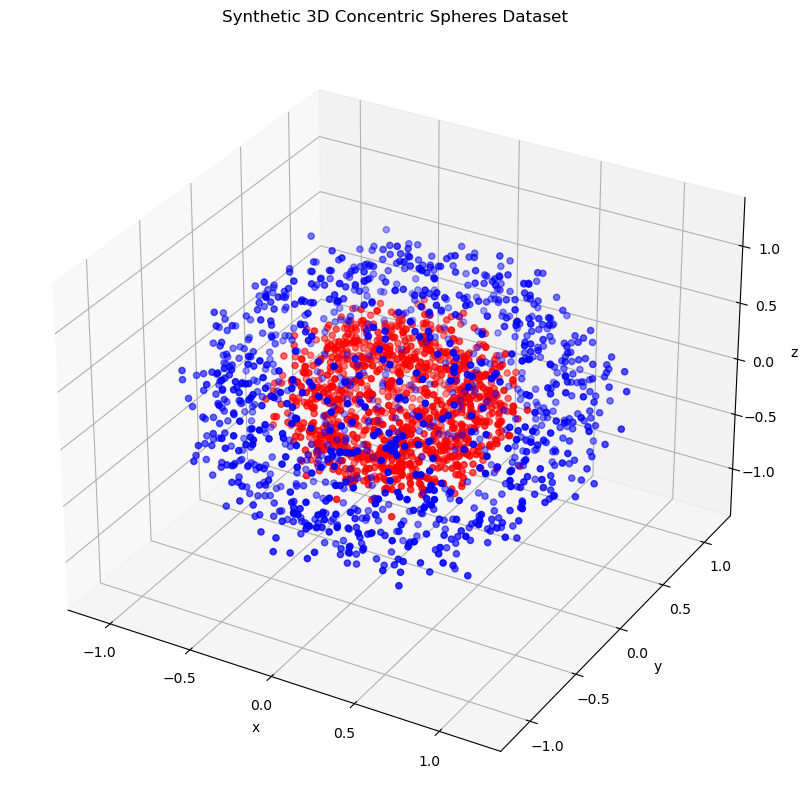

In [228]:
# Plot the dataset
X = data[['x', 'y', 'z']].values
y = data['target'].values

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y == 0, 0], X[y == 0, 1], X[y == 0, 2], color='red')
ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], color='blue')
plt.title('Synthetic 3D Concentric Spheres Dataset')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Save Main Data File

In [229]:
data.to_csv(outp_fname, index=False, float_format="%.4f")